**<center><font size=5>Brain Tumor Detection with Mask R-CNN</font></center>**

# DOWNLOAD

In [1]:
from IPython.display import clear_output

#MODEL - DOWNLOAD
!git clone https://github.com/atakanady/Mask_RCNN-_V1.git #Install Mask R-CNN code app

#DATASET - DOWNLOAD
# !git clone https://github.com/atakanady/brain-tumor.git #ORIGINAL DATASET
!git clone https://github.com/deeptangshu29/brain-tumor-detection.git
    
#DEPENDENCIES - DOWNLOAD
!pip install pycocotools #COCO is a large image dataset designed for object detection


#!rm -rf brain-tumor/.git/
#!rm -rf Mask_RCNN-_V1/.git/

# clear_output()

Cloning into 'Mask_RCNN-_V1'...
remote: Enumerating objects: 87, done.
remote: Total 87 (delta 0), reused 0 (delta 0), pack-reused 87 (from 1)
Unpacking objects: 100% (87/87), done.
Cloning into 'brain-tumor-detection'...
remote: Enumerating objects: 3066, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 3066 (delta 3), reused 13 (delta 2), pack-reused 3049 (from 1)
Receiving objects: 100% (3066/3066), 64.12 MiB | 52.30 MiB/s, done.
Resolving deltas: 100% (4/4), done.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.7-cp36-cp36m-linux_x86_64.whl size=304452 sha256=965240ec44d58f4362eaaaa689e4c9cbb346c93c6e436785a4ec8fdf8ac55041
  Stored in directory: /root/.cache/pip/wheels/03/a1/47/efb80a6d8627028f24df4b006f9c6e3e7ddf7b8560e6c3e6d7
Successfully built pycocotools


# Importing Dependencies

In [2]:
import os 
import sys
from tqdm import tqdm
import cv2
import numpy as np
import json
import skimage.draw
import matplotlib
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')
# Root directory of the project
ROOT_DIR = os.path.abspath('Mask_RCNN-_V1/')
sys.path.append(ROOT_DIR) 

from mrcnn.config import Config
from mrcnn import utils
from mrcnn.model import log
import mrcnn.model as modellib
from mrcnn import visualize
sys.path.append(os.path.join(ROOT_DIR, 'samples/coco/'))
import coco

plt.rcParams['figure.facecolor'] = 'white' #color selection of the background of the images.

# clear_output()

Using TensorFlow backend.


In [3]:
#Function created to control how large images will be rendered.
def get_ax(rows=1, cols=1, size=7):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# PATH Config

In [4]:
MODEL_DIR = os.path.join(ROOT_DIR, 'logs') # Saving the trained model.
DATASET_DIR = '/kaggle/working/brain-tumor-detection/data/' #'brain-tumor-detection/data/' #Directory containing image data.
DEFAULT_LOGS_DIR = 'logs' 

# Trained weights file path.
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# If information cannot be obtained from the trained model, download the COCO trained weights from the versions.
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


# Model Config

In [5]:
class TumorConfig(Config):
    
    # Adding name to configuration.
    NAME = 'tumor_detector'
    
    #We indicate how much GPU support will be provided.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    #Number of classes (including background)
    NUM_CLASSES = 1 + 1  # arkaplan + tümor
    
    #Use thumbnails for faster training. It determines the boundaries of the smaller side, is the big side and this determines the image shape.
    #IMAGE_MIN_DIM = 128
    #IMAGE_MAX_DIM = 128
    
    DETECTION_MIN_CONFIDENCE = 0.85    
    STEPS_PER_EPOCH = 100
    LEARNING_RATE = 0.001
    
config = TumorConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.85
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

**RESNET ARCHITECTURE**

![](https://miro.medium.com/max/500/1*JEGNYy9rXMj_XN7W1Qjo9g.png)

Above you see the VGG 19 model, a flat network with 34 parameter layers in the middle, and the residual network model with 34 parameter layers on the right. The model has fewer filters and lower complexity than VGG networks.

**ResNet 101**

By using more 3-layer blocks, 101-layer ResNets are created. 50/101/152-layer ResNets are significantly more accurate than 34-layer ones. Thanks to residual networks, distortion problems have been avoided and significant accuracy gains have been achieved from significantly increased depth.

**ResNet came first in COCO detection and COCO segmentation tasks.**

# PRE-Training Config

In [6]:
class BrainScanDataset(utils.Dataset):
   #Shapes form the synthetic dataset. The dataset consists of simple shapes (triangles, squares, circles) are placed randomly on a blank surface.
   #Images are created instantly. No file access required.
    
    
    def load_brain_scan(self, dataset_dir, subset):
         #generate any number of synthetic images.
         #count: number of images to create.
         #height,width: size of rendered images
        
        #adding class
        self.add_class("tumor", 1, "tumor")
        
        assert subset in ["train", "val", 'test']
        dataset_dir = os.path.join(dataset_dir, subset)

        annotations = json.load(open(os.path.join(DATASET_DIR, subset, 'annotation_' + subset + '.json')))
        annotations = list(annotations.values()) # no need for dict keys

        # VIA tool saves images to JSON even if they are not images.
        annotations = [a for a in annotations if a['regions']]

        # Add image
        for a in annotations:
            # X, Y coordinates are taken
            # if function to support x1 and x2 versions. necessary.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]

            # load_mask() needs the image size to convert polygons into masks.
            # Unfortunately, VIA doesn't include it in JSON, so we have to read it.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "tumor",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, 
                height=height,
                polygons=polygons
            )

            
            
            
    def load_mask(self, image_id):
        # If farm_cow is not a dataset image, grant permission to the superclass.
        image_info = self.image_info[image_id]
        if image_info["source"] != "tumor":
            return super(self.__class__, self).load_mask(image_id)
        
        # Convert polygons to a bitmap shape mask [height, width, number_instances]
        
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        
        for i, p in enumerate(info["polygons"]):
        # Get the pixel indexes inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
            
        # Return mask and array of class IDs of each instance. Since we have only one class ID, we return an array of 1.
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    
    
    
    
    
    def image_reference(self, image_id):
        #Return image path
        info = self.image_info[image_id]
        if info["source"] == "tumor":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

# <a id='import'>R-CNN Model</a>

In [7]:
#Creating a model for training mode.
model = modellib.MaskRCNN(
    mode='training', 
    config=config, 
    model_dir=DEFAULT_LOGS_DIR
)

model.load_weights(
    COCO_MODEL_PATH, 
    by_name=True, 
    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"]
)

In [8]:
#Training dataset
dataset_train = BrainScanDataset()
dataset_train.load_brain_scan(DATASET_DIR, 'train')
dataset_train.prepare()



#Validation Dataset
dataset_val = BrainScanDataset()
dataset_val.load_brain_scan(DATASET_DIR, 'val')
dataset_val.prepare()



#Test Dataset
dataset_test = BrainScanDataset()
dataset_test.load_brain_scan(DATASET_DIR, 'test')
dataset_test.prepare()




#Since we are using a very small data set and COCO trained weights, we do not need to run for too long. It is important not to go into overfitting mode.
print("Education Network")
model.train(
    dataset_train, dataset_val,
    learning_rate=config.LEARNING_RATE,
    epochs=20,
    layers='heads'
)

Education Network

Starting at epoch 0. LR=0.001

Checkpoint Path: logs/tumor_detector20250130T1656/mask_rcnn_tumor_detector_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed

In [9]:
# Rebuild the model in inference mode
model = modellib.MaskRCNN(
    mode="inference", 
    config=config,
    model_dir=DEFAULT_LOGS_DIR
)




# Get path to saved weights
# Either set a specific path or find the last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 filename here")
model_path = model.find_last()




# Load trained weights
print("Weights are loading", model_path)
model.load_weights(model_path, by_name=True)


Weights are loading logs/tumor_detector20250130T1656/mask_rcnn_tumor_detector_0020.h5
Re-starting from epoch 20


In [10]:
def predict_and_plot_differences(dataset, img_id):
    original_image, image_meta, gt_class_id, gt_box, gt_mask = modellib.load_image_gt(dataset, config,img_id, use_mini_mask=False)

    results = model.detect([original_image], verbose=0)
    r = results[0]

    visualize.display_differences(
        original_image,
        gt_box, gt_class_id, gt_mask,
        r['rois'], r['class_ids'], r['scores'], r['masks'],
        class_names = ['tumor'], title="", ax=get_ax(),
        show_mask=True, show_box=True
    )

In [11]:
def display_image(dataset, ind):
    plt.figure(figsize=(3,5))
    plt.imshow(dataset.load_image(ind))
    plt.xticks([])
    plt.yticks([])
    plt.title('Original Picture')


## Validation Set

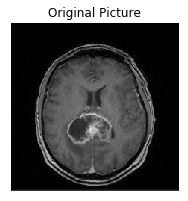

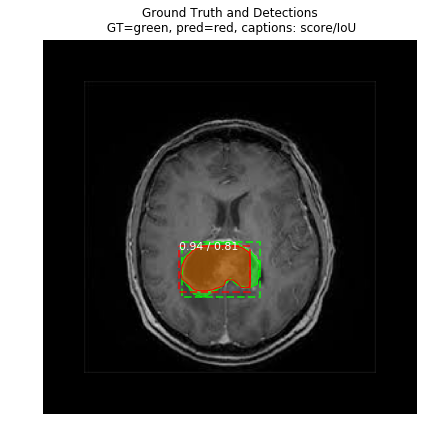

In [12]:
ind = 0
display_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind)

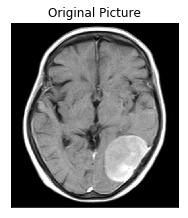

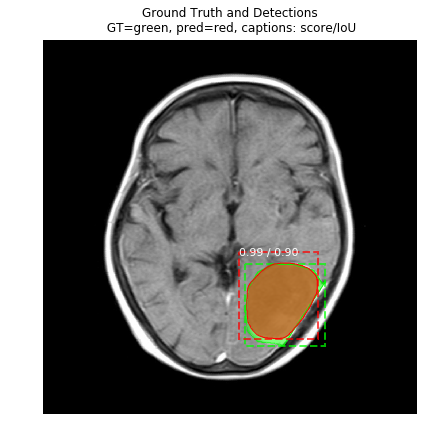

In [13]:
ind = 7
display_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind)

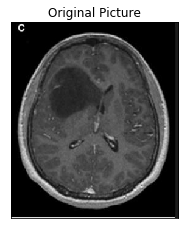

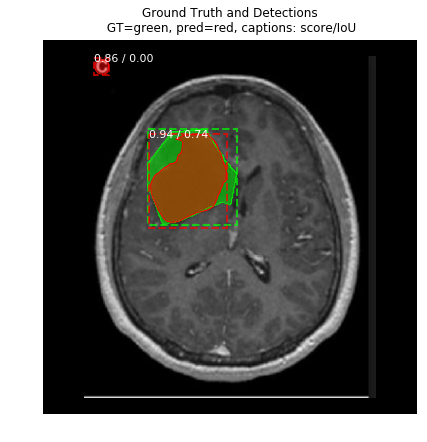

In [14]:
ind = 4
display_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind)

## Trial set

We'll see how the model performs in images it hasn't seen before.

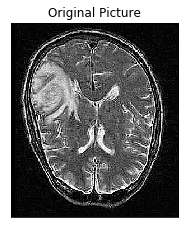

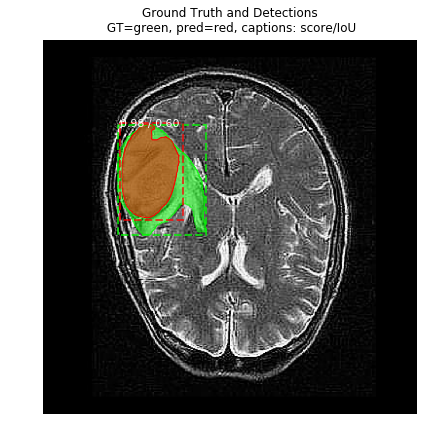

In [15]:
ind = 0
display_image(dataset_test, ind)
predict_and_plot_differences(dataset_test, ind)

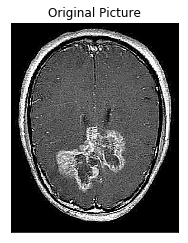

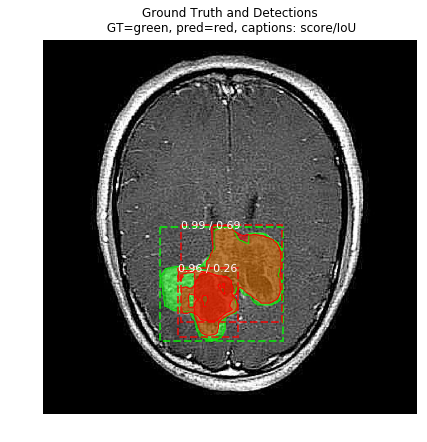

In [16]:
ind = 3
display_image(dataset_test, ind)
predict_and_plot_differences(dataset_test, ind)

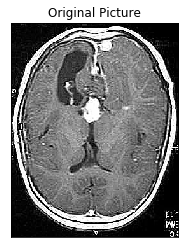

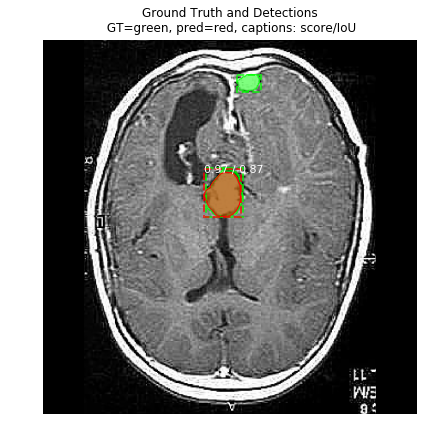

In [17]:
ind = 2
display_image(dataset_test, ind)
predict_and_plot_differences(dataset_test, ind)

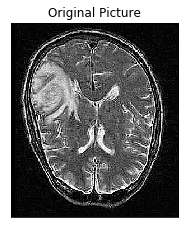

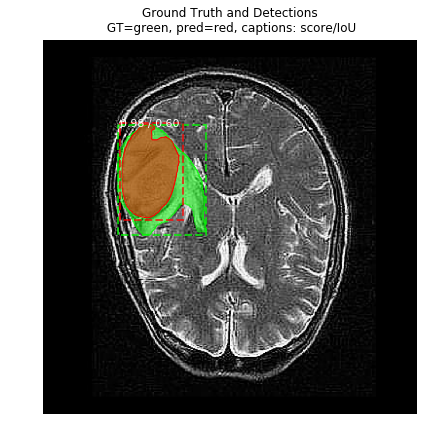

In [18]:
ind = 0
display_image(dataset_test, ind)
predict_and_plot_differences(dataset_test, ind)

# Accuracy 

In [19]:
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

# Compute accuracy on the test dataset
iou_threshold = 0.5  # IoU threshold for considering a detection as correct
correct_detections = 0
total_detections = 0
def compute_iou(gt_mask, pred_mask):
    # Convert ground truth mask to binary mask
    gt_mask_binary = np.any(gt_mask, axis=2).astype(int)
    
    # Convert predicted mask to binary mask
    pred_mask_binary = pred_mask > 0.5
    
    # Compute IoU
    intersection = np.logical_and(gt_mask_binary, pred_mask_binary)
    union = np.logical_or(gt_mask_binary, pred_mask_binary)
    iou = np.sum(intersection) / np.sum(union)
    
    return iou

for image_id in dataset_test.image_ids:
    original_image, _, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_test, config, image_id, use_mini_mask=False)
    results = model.detect([original_image], verbose=0)[0]  # Detect objects in the image
    
    # Compute IoU for each predicted mask
    for j in range(len(results['class_ids'])):
        mask_pred = results['masks'][:, :, j]
        iou = compute_iou(gt_mask, mask_pred)
        
        # Check if IoU is above the threshold
        if iou >= iou_threshold:
            correct_detections += 1
        total_detections += 1

accuracy = correct_detections / total_detections
print("Accuracy on Test Dataset:", accuracy)

# Confusion matrix
y_true = []
y_pred = []

for image_id in dataset_test.image_ids:
    _, _, gt_class_ids, _, _ = modellib.load_image_gt(dataset_test, config, image_id, use_mini_mask=False)
    results = model.detect([original_image], verbose=0)[0]  # Detect objects in the image
    
    for class_id in gt_class_ids:
        y_true.append(class_id)
        y_pred.append(results['class_ids'][0])  # Assuming only one detection per image

confusion_mtx = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(confusion_mtx)

# Classification report and other metrics
print("Classification Report:")
print(metrics.classification_report(y_true, y_pred))


Accuracy on Test Dataset: 0.47433264887063653
Confusion Matrix:
[[316]]
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       316

    accuracy                           1.00       316
   macro avg       1.00      1.00      1.00       316
weighted avg       1.00      1.00      1.00       316



In [20]:
from sklearn.metrics import  accuracy_score,precision_score
import sklearn.metrics as metrics

# Compute and print accuracy, precision, recall, F1 score, ROC AUC score, and Cohen Kappa score
print('Accuracy score:', np.round(metrics.accuracy_score(y_true, y_pred), 4))
print('Precision score:', np.round(metrics.precision_score(y_true, y_pred, average='weighted'), 4))
print('Recall score:', np.round(metrics.recall_score(y_true, y_pred, average='weighted'), 4))
print('F1 Score:', np.round(metrics.f1_score(y_true, y_pred, average='weighted'), 4))
#print('ROC AUC Score:', np.round(metrics.roc_auc_score(y_true, mask_pred), 4))  # Remove multi_class parameter
#print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_true, y_pred), 4))

# Print the classification report
print('\nClassification Report:\n', metrics.classification_report(y_true, y_pred))


Accuracy score: 1.0
Precision score: 1.0
Recall score: 1.0
F1 Score: 1.0

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       316

    accuracy                           1.00       316
   macro avg       1.00      1.00      1.00       316
weighted avg       1.00      1.00      1.00       316



# accu

In [23]:
# gt = ground truth (green zone) / predict = model prediction (red zone)
def get_iou(gt, pred):
    intersection = np.logical_and(gt, pred)
    union = np.logical_or(gt, pred)
    iou_score = np.sum(intersection > 0) / np.sum(union > 0)
    return iou_score

In [24]:
# get some performance metrics
from sklearn.metrics import confusion_matrix, classification_report
import sklearn.metrics as metrics

# precision of the model 
# true positives / (true positives + false positives)
def get_precision(gt, pred):
    if pred.shape[-1] == 0:  # Check if there are no predicted masks
        return 0.0
    gt_binary = (gt > 0).astype(int)
    pred_binary = (pred > 0.5).astype(int)  # Assuming 0.5 threshold for binary classification
    intersection = np.logical_and(gt_binary[:, :, 0], pred_binary[:, :, 0])  # Considering only the first channel
    precision = np.sum(intersection) / np.sum(pred_binary[:, :, 0])
    return precision

# recall of the model
# true positives / (true positives + false negatives)
def get_recall(gt, pred):
    if pred.shape[-1] == 0:  # Check if there are no predicted masks
        return 0.0
    gt_binary = (gt > 0).astype(int)
    pred_binary = (pred > 0.5).astype(int)  # Assuming 0.5 threshold for binary classification
    intersection = np.logical_and(gt_binary[:, :, 0], pred_binary[:, :, 0])  # Considering only the first channel
    recall = np.sum(intersection) / np.sum(gt_binary[:, :, 0])
    return recall

# f1 score of the model
# 2 * (precision * recall) / (precision + recall)
def get_f1_score(gt, pred):
    precision = get_precision(gt, pred)
    recall = get_recall(gt, pred)
    if precision + recall == 0:
        return 0.0
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

# get Intersection over Union (IoU)
def get_iou(gt, pred):
    if pred.shape[-1] == 0:  # Check if there are no predicted masks
        return 0.0
    intersection = np.logical_and(gt[:, :, 0], pred[:, :, 0])  # Considering only the first channel
    union = np.logical_or(gt[:, :, 0], pred[:, :, 0])  # Considering only the first channel
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

# get precision, recall and f1 score of all images
precisions = []
recalls = []
f1_scores = []
ious = []
for img_id in dataset_test.image_ids:
    original_image, image_meta, gt_class_id, gt_box, gt_mask =\
        modellib.load_image_gt(dataset_test, config, 
                               img_id, use_mini_mask=False)

    results = model.detect([original_image], verbose=0)
    r = results[0]
    
    precision = get_precision(gt_mask, r['masks'])
    recall = get_recall(gt_mask, r['masks'])
    f1_score = get_f1_score(gt_mask, r['masks'])
    iou = get_iou(gt_mask, r['masks'])
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)
    ious.append(iou)
    
    #remove nan
precisions = [precision for precision in precisions if not np.isnan(precision)]
recalls = [recall for recall in recalls if not np.isnan(recall)]
f1_scores = [f1_score for f1_score in f1_scores if not np.isnan(f1_score)]
ious = [iou for iou in ious if not np.isnan(iou)]


In [25]:
# Printing performance metrics
print('Mean Precision: ', np.mean(precisions))
print('Mean Recall: ', np.mean(recalls))
print('Mean F1 Score: ', np.mean(f1_scores))
print('Mean IoU: ', np.mean(ious))

Mean Precision:  0.7482245167350116
Mean Recall:  0.666386936238315
Mean F1 Score:  0.6830002258927902
Mean IoU:  0.6008137846850249


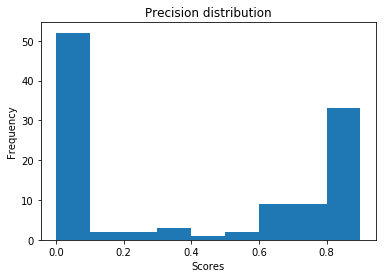

In [26]:
def hist_metric(name, metrics, nb_bins=10):
  bins = np.arange(0, 100, nb_bins)/100
  plt.hist(metrics, bins)
  plt.title(name + " distribution")
  plt.xlabel("Scores")
  plt.ylabel("Frequency")
  plt.show()

hist_metric('Precision', precisions, 10)

# Diagrams

In [33]:
!pip install pydot graphviz

In [34]:
import os
import sys
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from mrcnn import model as modellib
from mrcnn.config import Config

# Set up paths and directories
ROOT_DIR = os.path.abspath("/kaggle/working/")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Load the pre-trained COCO weights if necessary
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "Mask_RCNN-_V1/mask_rcnn_coco.h5")

# Define the configuration for the model
class BrainTumorConfig(Config):
    NAME = "brain_tumor"
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # Background + tumor
    STEPS_PER_EPOCH = 100
    DETECTION_MIN_CONFIDENCE = 0.9

# Instantiate the configuration
config = BrainTumorConfig()

# Create the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=config, model_dir=MODEL_DIR)

# Load weights (pre-trained on COCO)
model.load_weights(COCO_MODEL_PATH, by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", 
                            "mrcnn_mask"])

# Visualize the model architecture
plot_model(model.keras_model, to_file="mask_rcnn_architecture.png", show_shapes=True, show_layer_names=True)
